## Prediction and explnation model

In [1]:
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning)

filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.object` is a deprecated alias')
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.float` is a deprecated alias')


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import os
from utils.eval_utils import evaluate_regression_metrics, normalize_dataframe, create_stratified_splits

random_state = 1

In [ ]:
directory = 'D:\...\TOC_features4' #Covariates

# Get list of files in the directory
# files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
files = [os.path.splitext(f)[0] for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

print(len(files))
# Now files will contain only filenames that do not end with ".tif"

48


In [4]:
# Read data
df_main = pd.read_csv ('input_features.csv')
y_max = df_main.iloc[:,0].max()
y_min = df_main.iloc[:,0].min()

df = normalize_dataframe(df_main)

Ins and Outs for models

In [5]:
y = df.iloc[:,0]
X = df.iloc[:,3:]

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = create_stratified_splits(X, y, random_state=random_state)

In [7]:
# Assuming X and y are defined as before
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Reshape y_train
y_train_array = y_train.values  # Convert DataFrame to NumPy array
y_train_reshaped = y_train_array.reshape((len(y_train_array), -1))

# Reshape X_train
X_train_array = X_train.values  # Convert DataFrame to NumPy array
X_train_reshaped = X_train_array.reshape((len(X_train_array), -1))

# Reshape y_test
y_test_array = y_test.values  # Convert DataFrame to NumPy array
y_test_reshaped = y_test_array.reshape((len(y_test_array), -1))

# Reshape X_test
X_test_array = X_test.values  # Convert DataFrame to NumPy array
X_test_reshaped = X_test_array.reshape((len(X_test_array), -1))

### Naive model for comparison 

In [8]:
# # Calculate mean value of the data
# mean_value = np.mean(y_train_reshaped)

# # Create array with mean value of the data
# y_pred = np.full_like(y_train_reshaped, mean_value)

# # denormalization in order to calculate the metrics
# y_train_denormal = (y_max - y_min)* y_train_reshaped + y_min
# y_pred_denormal = (y_max - y_min)* y_pred + y_min

# rmse, r2, rpiq, mae, ccc = evaluate_regression_metrics(y_train_denormal.flatten(), y_pred_denormal.flatten())

# print(rmse, r2, rpiq, mae, ccc)

### Choose the prediction model

In [9]:
ML = 'GB' # other options: 'RF','GB','Ridge','DeepForest','NN'

In [ ]:
# Only models with the best hyperparamters are included. See: https://scikit-learn.org/1.5/modules/grid_search.html#

if ML == 'DeepForest':
    from deepforest import CascadeForestRegressor
    # Specify the backend as 'sklearn'
    # model = CascadeForestRegressor(backend="sklearn")
    model = CascadeForestRegressor(random_state = random_state)

elif ML == 'RF':
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(n_estimators = 200, max_depth = 3, random_state=random_state)

elif ML == 'GB':
    from sklearn.ensemble import GradientBoostingRegressor
    model = GradientBoostingRegressor(n_estimators= 1000, learning_rate= 0.05, random_state=random_state)


elif ML == 'Ridge':
  from sklearn import linear_model
#   from sklearn.linear_model import LinearRegression

#   model = linear_model.Lasso()
  model = linear_model.Ridge(alpha=.5)

#   model = LinearRegression()

elif ML == 'NN':
    # Assuming you are using TensorFlow
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.optimizers import Adam

    np.random.seed(random_state)
    tf.random.set_random_seed(random_state)

    # Define the neural network model
    model = Sequential([
        Dense(128, activation='relu', input_shape=(len(files),)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer with 1 neuron for regression
    ])

    # Compile the model with Adam optimizer and mean squared error loss
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

else:
    raise ValueError("Invalid ML option. Please choose from 'DeepForest', 'RF', 'GB', 'LinearRegression', or 'NN'.")

if ML == 'NN':
    # Train the model with a specified number of epochs
    model.fit(X_train, y_train, epochs=100, batch_size=16)
else: 
    model.fit(X_train_reshaped, y_train_reshaped)

# Make predictions
y_pred = model.predict(X_test_reshaped)

c:\Users\nkakhani\anaconda3\envs\tfone_DeepRF_Captum\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Evaluation metrics for test samples

In [11]:
# denormalization in order to calculate the metrics
y_test_denormal = (y_max - y_min)* y_test_reshaped + y_min
y_pred_denormal = (y_max - y_min)* y_pred + y_min

rmse, r2, rpiq, mae, ccc = evaluate_regression_metrics(y_test_denormal.flatten(), y_pred_denormal.flatten())

print(rmse, r2, rpiq, mae, ccc)

50.48991114509147 0.11094448576032623 0.6077918050510953 22.76788401033129 0.38765934946333985


# Explanation Section

In [ ]:
# filterwarnings(action='ignore', category=DeprecationWarning)
import os
from tensorflow.python.keras.losses import mean_squared_error
from cxplain import MLPModelBuilder, RNNModelBuilder,UNetModelBuilder, ZeroMasking, WordDropMasking, CXPlain

directory = 'D:\...\TOC_features4'

# Get list of files in the directory
# files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
files = [os.path.splitext(f)[0] for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]


modified_names = ['aet', 'An Hill', 'Aspect', 'BulkDensity', 'Ch Net Ba Le', 
 'Ch Net Dis', 'Clay', 'Cl De', 'Conv Ind', 'def', 
 'HLS bi', 'HLS blue', 'HLS evi', 'HLS gemi', 'HLS gli', 'HLS green', 'HLS ndvi', 'HLS nir', 
 'HLS red', 'HLS swir1', 'HLS swir2', 'LS Factor', 'MODIS tree', 'NPP', 
 'PALSAR Forest', 'Pdsi', 'pet', 'pH', 'Pl Curv', 'pr', 'Prof Cur', 
 'Rel Slope Pos', 'Runoff', 'Slope', 'Soil Mo', 'Srad', 'Elevation', 'Taxonomy', 
 'Texture', 'tmmn', 'tmmx', 'TWI', 'TCA', 
 'Valley Depth', 'vap', 'vpd', 'vs', 'Watercontent']

### Model specific feature importance

In [13]:
import pandas as pd

# Define the file paths for saving the CSV files
rf_csv_file = "RF_feature_importance.csv"
gb_csv_file = "GB_feature_importance.csv"
ridge_csv_file = "ridge_feature_importance.csv"

if ML == 'RF':
    from sklearn.ensemble import RandomForestRegressor
    importances = model.feature_importances_
    feature_importance = pd.DataFrame({'Feature': modified_names, 'Importance': importances})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    feature_importance.to_csv(rf_csv_file, index=False)  # Save feature importance to CSV file

elif ML == 'GB':
    from sklearn.ensemble import GradientBoostingRegressor
    importances = model.feature_importances_
    feature_importance = pd.DataFrame({'Feature': modified_names, 'Importance': importances})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    feature_importance.to_csv(gb_csv_file, index=False)  # Save feature importance to CSV file

elif ML == 'Ridge':
    from sklearn.linear_model import Ridge
    coefficients = model.coef_

    # Ensure one-dimensional arrays or lists
    modified_names = np.array(modified_names).flatten()
    coefficients = np.array(coefficients).flatten()

    feature_importance = pd.DataFrame({'Feature': modified_names, 'Coefficient': abs(coefficients)})
    feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
    feature_importance.to_csv(ridge_csv_file, index=False)  # Save feature importance to CSV file

else:
    print('No feature importance file saved.')


In [14]:
#* Double check for GB
# from matplotlib import pyplot as plt

# feature_importances = model.feature_importances_ * 100
# normalized_values = (feature_importances - np.min(feature_importances)) / (np.max(feature_importances) - np.min(feature_importances))
# colors2 = plt.cm.GnBu(normalized_values)

# plt.figure(figsize = (6,12))
# plt.barh(modified_names, np.round((model.feature_importances_*100),2), color = colors2)

### Supervised training for explanation

In [15]:
# MLP
model_builder = MLPModelBuilder(num_layers=2, num_units= len(files), activation="selu", p_dropout=0.2, verbose=0,
                                batch_size=8, learning_rate=0.01, num_epochs=250, early_stopping_patience=15)

# # RNN 
# model_builder = RNNModelBuilder(num_layers=2, num_units= len(files))


# How you want to mask our samples
masking_operation = ZeroMasking()
loss = mean_squared_error


explainer_reg = CXPlain(model, model_builder, masking_operation, loss, num_models=10)
explainer_reg.fit(X_train_reshaped, y_train_reshaped)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


TensorflowCXPlain(explained_model=GradientBoostingRegressor(learning_rate=0.05,
                                                            n_estimators=1000,
                                                            random_state=1),
                  loss=<function mean_squared_error at 0x000001D51F5A9708>,
                  masking_operation=<cxplain.backend.masking.zero_masking.ZeroMasking object at 0x000001D521E63C88>,
                  model_builder=<cxplain.backend.model_builders.mlp.MLPModelBuilder object at 0x000001D521E63DC8>,
                  num_models=10)

In [16]:
# attributions and confidence for test samples 
attributions_reg, confidence_reg = explainer_reg.explain(X_train_reshaped, confidence_level=0.80)


print(attributions_reg[152,:].sum())
print(confidence_reg.shape)
print(attributions_reg.shape)

0.96835405
(1348, 48, 2)
(1348, 48)


In [17]:
import os
os.getcwd()
import numpy as np
import matplotlib.pyplot as plt
from cxplain.visualisation.plot import Plot

plt.rcdefaults()

# np.random.seed(1416)
selected_index = np.random.randint(len(X_test_reshaped))
print(selected_index)
selected_sample = X_test_reshaped[selected_index]
importances = attributions_reg[selected_index]*100
importances_confidence = confidence_reg[selected_index]*100

246


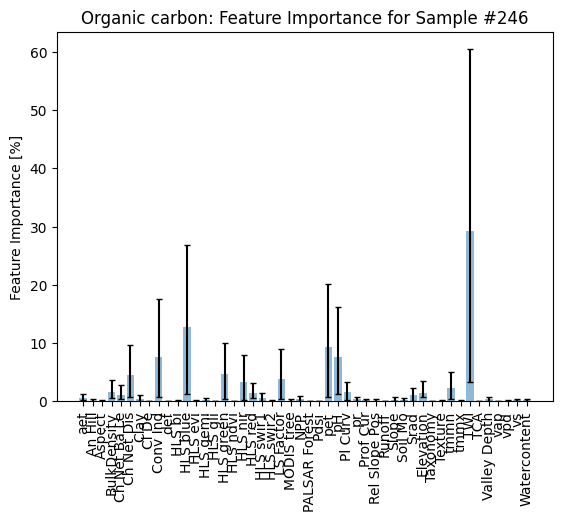

<Figure size 640x480 with 0 Axes>

In [18]:
Plot.plot_attribution_1d(selected_sample, importances, importances_confidence, run_without_gui = False,\
                         title='Organic carbon: Feature Importance for Sample #{}'.format(selected_index), 
                         feature_names = modified_names)

### Model deployment for a large number of samples

In [19]:
# Read data
df_main_all = pd.read_csv ('input_features_all.csv')

df_all = normalize_dataframe(df_main_all)

X_all = df_all.iloc[:,4:]

# Reshape X_train
X_array = X_all.values  # Convert DataFrame to NumPy array
X_reshaped = X_array.reshape((len(X_array), -1))

In [20]:
# Explanation model
attributions_reg_all, confidence_reg_all = explainer_reg.explain(X_reshaped, confidence_level=0.80)

In [21]:
# Prediction model
y_soc = model.predict(X_reshaped)

y_soc_denormal = (y_max - y_min)* y_soc + y_min


# Method 2: Simply assigning values to a new column
df_main_all['SOC'] = y_soc_denormal

df_main_all.to_csv(f"SOC_{ML}.csv", index=False)

In [22]:
print(attributions_reg_all.shape)

(173114, 48)


166383


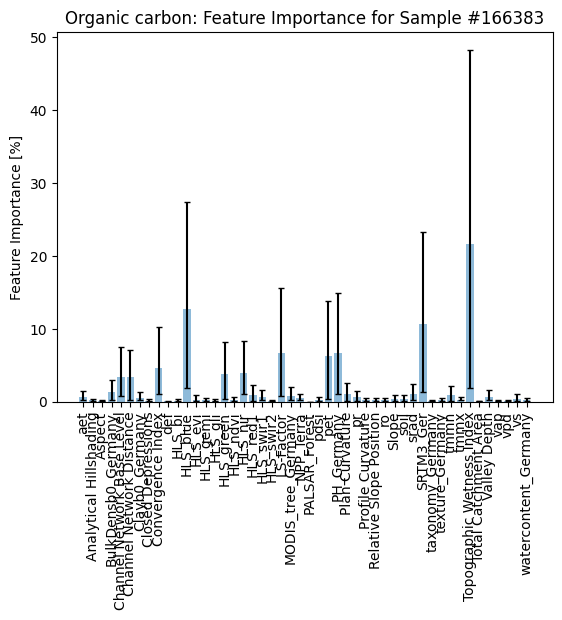

<Figure size 640x480 with 0 Axes>

In [23]:
selected_index = np.random.randint(len(X_reshaped))
print(selected_index)
selected_sample = X_reshaped[selected_index]
importances = attributions_reg_all[selected_index]*100
importances_confidence = confidence_reg_all[selected_index]*100

Plot.plot_attribution_1d(selected_sample, importances, importances_confidence, run_without_gui = False,\
                         title='Organic carbon: Feature Importance for Sample #{}'.format(selected_index), 
                         feature_names = files)

In [24]:
# Convert the data array and column names array to a pandas DataFrame
df = pd.DataFrame(attributions_reg_all, columns = files)
# Concatenate the original DataFrame and the additional DataFrame along the columns axis
final_df = pd.concat([df, df_main_all.iloc[:,0:2]], axis=1)

# Chosse the name based on the explnation method you hve used
# final_df.to_csv("Att_MLP_ZeroMasking.csv", index=False)
final_df.to_csv(f"Att_MLP_ZeroMasking_{ML}.csv", index=False)